In [1]:
#Importing Data from the CSV file
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import seaborn as sns
import time

In [116]:
def input_read(file, sep, class0, class1):
    myFile = pd.read_csv(file, sep=sep, header=None, index_col=False)
    df_train = myFile
    train_classes = df_train[784]
    train_classes = (train_classes.apply(lambda x: 1 if (x==class1) else -1))*1.
    train_classes.index = np.arange(0, len(df_train))
    df_train = df_train.drop(784, axis=1)
    df_train.index=(np.arange(0, len(df_train)))
    df_train /= 255
    return df_train.to_numpy(), train_classes.to_numpy();

In [194]:
def linear_svm_cvxopt(X_train, train_classes, c=1):
    m,n = X_train.shape
    XY = train_classes*X_train
    temp_P= np.dot(XY, XY.T)
    P = cvxopt_matrix(temp_P)
    q = cvxopt_matrix(-1*np.ones((m,1)))
    G1 =-1*np.eye(m)
    G2 =c*np.eye(m)
    G = cvxopt_matrix(np.vstack((G1,G2)))
    h1 = np.zeros(m)
    h2 = np.ones(m)*c
    h = cvxopt_matrix(np.hstack((h1,h2)))
    A = cvxopt_matrix(train_classes.reshape(1,-1)*1.)
    b = cvxopt_matrix(np.zeros(1))
    cvx_solver = cvxopt_solvers.qp(P, q, G, h, A, b)
    alpha = np.array(cvx_solver['x'])
    w = np.dot((train_classes * alpha).T, X_train).reshape(-1,1)
    temp = np.dot(X_train,w)
    index_1 = np.where(train_classes==1)[0]
    index_0 = np.where(train_classes==-1)[0]
    b = (max(temp[index_0])+min(temp[index_1]))*-0.5
    return alpha, w, b;

In [161]:
def calc_accuracy(classes, pred_classes):   
    acc = 0
    for i in range(len(classes)):
        if (classes[i]==pred_classes[i]):
            acc+=1
    acc = (acc/len(classes))*100
    return acc

In [117]:
X_train, train_classes = input_read('fashion_mnist/train.csv', ',', 3, 4)
X_val, val_classes = input_read('fashion_mnist/val.csv', ',', 3, 4)
X_test, test_classes = input_read('fashion_mnist/test.csv', ',', 3, 4)

In [124]:
train_classes = train_classes.reshape(-1,1)
m,n = X_train.shape
c=1 #penalty weight


In [195]:
alpha, w, b = linear_svm_cvxopt(X_train, train_classes, c)

     pcost       dcost       gap    pres   dres
 0: -7.6996e+02 -9.4221e+03  5e+04  3e+00  5e-12
 1: -5.0971e+02 -5.5267e+03  1e+04  4e-01  5e-12
 2: -3.4948e+02 -1.8871e+03  3e+03  1e-01  3e-12
 3: -2.7529e+02 -9.4339e+02  1e+03  4e-02  3e-12
 4: -2.3683e+02 -5.8695e+02  6e+02  2e-02  3e-12
 5: -2.1335e+02 -3.9050e+02  3e+02  6e-03  3e-12
 6: -2.1473e+02 -2.5858e+02  6e+01  9e-04  4e-12
 7: -2.1941e+02 -2.3321e+02  2e+01  2e-04  4e-12
 8: -2.2236e+02 -2.2552e+02  3e+00  2e-05  4e-12
 9: -2.2339e+02 -2.2362e+02  2e-01  6e-07  4e-12
10: -2.2348e+02 -2.2349e+02  1e-02  3e-08  4e-12
11: -2.2348e+02 -2.2348e+02  2e-04  5e-10  4e-12
Optimal solution found.


In [263]:
def predict(X_train, X_val, X_test, train_classes, val_classes, test_classes, w, b):
    
    train_pred = [1.0 if x >=0 else -1. for x in (np.dot(X_train,w) + b) ]
    train_acc = calc_accuracy(train_classes, train_pred)

    val_pred = [1. if x >=0 else -1. for x in (np.dot(X_val,w) + b) ]
    val_acc = calc_accuracy(val_classes, val_pred)

    test_pred = [1. if x >=0 else -1. for x in (np.dot(X_test,w) + b) ]
    test_acc = calc_accuracy(test_classes, test_pred)
    
    return train_acc, val_acc, test_acc;

In [265]:
train_acc, val_acc, test_acc = predict(X_train, X_val, X_test, train_classes, val_classes, test_classes, w, b)

In [266]:
print("The training accuracy of the model is = {:2.3f}%".format(train_acc))
print("The Validation accuracy of the data set is= {:2.3f}%".format(val_acc))
print("The test accuracy of the model is = {:2.3f}%".format(test_acc))

The training accuracy of the model is = 98.622%
The Validation accuracy of the data set is= 93.600%
The test accuracy of the model is = 94.500%


In [253]:
def sklearn_svm(X_train, train_classes, shape):
    svc_classifier = svc(kernel=shape)
    svc_classifier.fit(X_train, train_classes[:,0])
    train_pred_svc = svc_classifier.predict(X_train)
    val_pred_svc = svc_classifier.predict(X_val)
    test_pred_svc = svc_classifier.predict(X_test)
    train_acc_svc = svc_classifier.score(X_train, train_classes)
    val_acc_svc = svc_classifier.score(X_val, val_classes)
    test_acc_svc = svc_classifier.score(X_test, test_classes)
    return train_acc_svc, val_acc_svc, test_acc_svc;

In [251]:
train_acc_svc, val_acc_svc, test_acc_svc = sklearn_svm(X_train, train_classes, 'linear')

In [252]:
print("The training accuracy of the SVM model is = {:2.3f}%".format(train_acc_svc*100))
print("The Validation accuracy of the SVM model is= {:2.3f}%".format(val_acc_svc*100))
print("The test accuracy of the SVM model is = {:2.3f}%".format(test_acc_svc*100))

The training accuracy of the SVM model is = 98.622%
The Validation accuracy of the SVM model is= 93.400%
The test accuracy of the SVM model is = 94.300%


In [202]:
conf_matrix_cvxopt = confusion_matrix(test_classes, test_pred)
conf_matrix_svmC = confusion_matrix(test_classes, test_pred_svc)

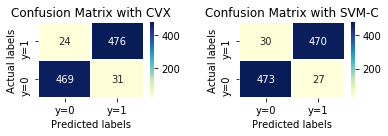

In [246]:
#Print confusion matrix (Code help from stackoverflow)
fig = plt.figure()
ax= fig.add_subplot(221)
sns.heatmap(conf_matrix_cvxopt, annot=True, ax = ax, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
ax.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
ax.set_ylabel('Actual labels');
ax.set_xlabel('Predicted labels'); 
ax.set_title('Confusion Matrix with CVX'); 
ax.xaxis.set_ticklabels(['y=0', 'y=1']); ax.yaxis.set_ticklabels(['y=0', 'y=1']);

ax1 = fig.add_subplot(222)
sns.heatmap(conf_matrix_svmC, annot=True, ax = ax1, fmt="d",linewidths=1, cmap="YlGnBu"); #annot=True to annotate cells
ax1.set_ylim([0,2]) # Workaround to display values in the center, to avoid downgrade to matplotlib3.1.1
ax1.set_ylabel('Actual labels');
ax1.set_xlabel('Predicted labels'); 
ax1.set_title('Confusion Matrix with SVM-C'); 
ax1.xaxis.set_ticklabels(['y=0', 'y=1']); ax1.yaxis.set_ticklabels(['y=0', 'y=1']);

fig.tight_layout(pad=3.0)

plt.show()

In [ ]:
# def gauss_kernel_cvxopt(X_train, train_classes, c=1):
m,n = X_train.shape
K = np.zeros((m,m))
gamma = 0.05
start = time.time()
for i in range(m):
    for j in range(m):
        K[i,j] = np.exp(-1*gamma*np.linalg.norm(X_train[i]-X_train[j])**2)

end = time.time()
print("Time to Calculate Gaussian Kernel matrix for CVXOPT= {}s".format(end-start))

#     XY = train_classes*X_train
#     temp_P= np.dot(XY, XY.T)
P = cvxopt_matrix(np.outer(train_classes, train_classes)*K)
q = cvxopt_matrix(-1*np.ones((m,1)))
G1 =-1*np.eye(m)
G2 =c*np.eye(m)
G = cvxopt_matrix(np.vstack((G1,G2)))
h1 = np.zeros(m)
h2 = np.ones(m)*c
h = cvxopt_matrix(np.hstack((h1,h2)))
A = cvxopt_matrix(train_classes.reshape(1,-1)*1.)
b = cvxopt_matrix(np.zeros(1))
cvx_solver = cvxopt_solvers.qp(P, q, G, h, A, b)
print(cvx_solver)
alpha = np.array(cvx_solver['x'])
w = np.dot((train_classes * alpha).T, X_train).reshape(-1,1)
temp = np.dot(X_train,w)
index_1 = np.where(train_classes==1)[0]
index_0 = np.where(train_classes==-1)[0]
b = (max(temp[index_0])+min(temp[index_1]))*-0.5
    #return alpha, w, b;

In [271]:
alpha_g, w, b = gauss_kernel_cvxopt(X_train, train_classes, c)

Time to Calculate Gaussian Kernel matrix for CVXOPT= 198.7432825565338s
     pcost       dcost       gap    pres   dres
 0: -4.2846e+02 -7.6683e+03  3e+04  2e+00  2e-15
 1: -3.2882e+02 -4.1247e+03  6e+03  2e-01  2e-15
 2: -3.0989e+02 -9.4797e+02  7e+02  2e-02  3e-15
 3: -3.7592e+02 -5.6057e+02  2e+02  4e-03  2e-15
 4: -4.0510e+02 -4.5864e+02  6e+01  7e-04  2e-15
 5: -4.1586e+02 -4.3199e+02  2e+01  1e-04  2e-15
 6: -4.1976e+02 -4.2383e+02  4e+00  1e-05  2e-15
 7: -4.2092e+02 -4.2164e+02  7e-01  1e-13  3e-15
 8: -4.2117e+02 -4.2123e+02  6e-02  5e-14  2e-15
 9: -4.2119e+02 -4.2119e+02  1e-03  2e-14  3e-15
10: -4.2119e+02 -4.2119e+02  2e-05  5e-14  3e-15
Optimal solution found.


In [273]:
train_acc, val_acc, test_acc = predict(X_train, X_val, X_test, train_classes, val_classes, test_classes, w, b)

In [274]:
print("-----------GAUSSIAN KERNEL----------------")

print("The training accuracy of the model is = {:2.3f}%".format(train_acc))
print("The Validation accuracy of the data set is= {:2.3f}%".format(val_acc))
print("The test accuracy of the model is = {:2.3f}%".format(test_acc))

-----------GAUSSIAN KERNEL----------------
The training accuracy of the model is = 98.622%
The Validation accuracy of the data set is= 93.600%
The test accuracy of the model is = 94.500%
